In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
filename_prefix = "pvc_"

In [3]:
#path = r"/home/perdelt/benchmarks"

In [4]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean',
        'Latency Distribution.99th Percentile Latency (microseconds)': 'max',
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [5]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    show_height = False
    if show_height:
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X: center of bar
                    height,                             # Y: top of bar
                    f'{height:.1f}',                    # Text (1 decimal place)
                    ha='center', va='bottom', fontsize=8
                )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



In [6]:
def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Container

In [7]:
codes = [
    # container
    '1750849896', #tenants=1
    '1750855816', #tenants=2
    '1750851609', #tenants=3
    '1750853501', #tenants=4
    '1750800801', #tenants=5
    '1750806919', #tenants 6
    '1750813297', #tenants=7
    '1750819742', #tenants=8
    '1750826579', #tenants=9
    '1750840810', #tenants=10
    
    # database
    '1750848184', #tenants=1
    '1750782080', #tenants=2
    '1750787463', #tenants=3
    '1750793061', #tenants=4
    '1750798872', #tenants=5
    '1750804904', #tenants=6
    '1750811177', #tenants=7
    '1750817654', #tenants=8
    '1750824366', #tenants=9
    '1750831264', #tenants=10
    
    #schema
    '1750846468', #tenants=1
    '1750780338', #tenants=2
    '1750796864', #tenants=5
    '1750785678', #tenants=3
    '1750791210', #tenants=4
    '1750802821', #tenants=6   
    '1750809059', #tenants=7
    '1750815548', #tenants=8
    '1750822119', #tenants=9
    '1750829043', #tenants=10
]

In [8]:
df_performance = get_performance_all_single(codes)
df_performance

,connection,configuration,experiment_run,client,pod,pod_count,bench,profile,target,time,...,Latency Distribution.Maximum Latency (microseconds),Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds),type,num_tenants
connection_pod,,,,,,,,,,,,,,,,,,,,,
PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0,1,1,5t5rh.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2937806,50414,751,19119,122746,267072,95586,62914,container,1
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,v8x7q.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1629694,19983,831,13852,50701,109435,31777,26257,container,1
PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-1,1,1,vgnbg.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2020130,46089,710,21150,113815,238923,84251,58277,container,2
PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0,1,1,zt8cs.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,3266881,48794,719,21856,116340,357056,83669,63302,container,2
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,975q2.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2012412,21552,712,13183,61075,124446,37980,29584,container,2
PostgreSQL-1-1-65536-1-2-1,PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-1,1,2,d24hd.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1411061,21211,708,13048,60920,124921,37561,29340,container,2
PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0,1,1,wf55j.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1467268,42352,751,22777,107103,233636,70775,54058,container,3
PostgreSQL-1-1-65536-2-1-1,PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-2,1,1,nhr99.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2681879,44086,770,23308,109655,232985,74039,55549,container,3
PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-1,1,1,8lnsk.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2991875,44434,653,23623,112596,241362,74858,56680,container,3


In [9]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

connection           configuration  \
num_tenants type                                                          
1           container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
2           container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
3           container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
4           container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
5           container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
6           container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
7           container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-6-1  PostgreSQL-1-1-65536-6   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-

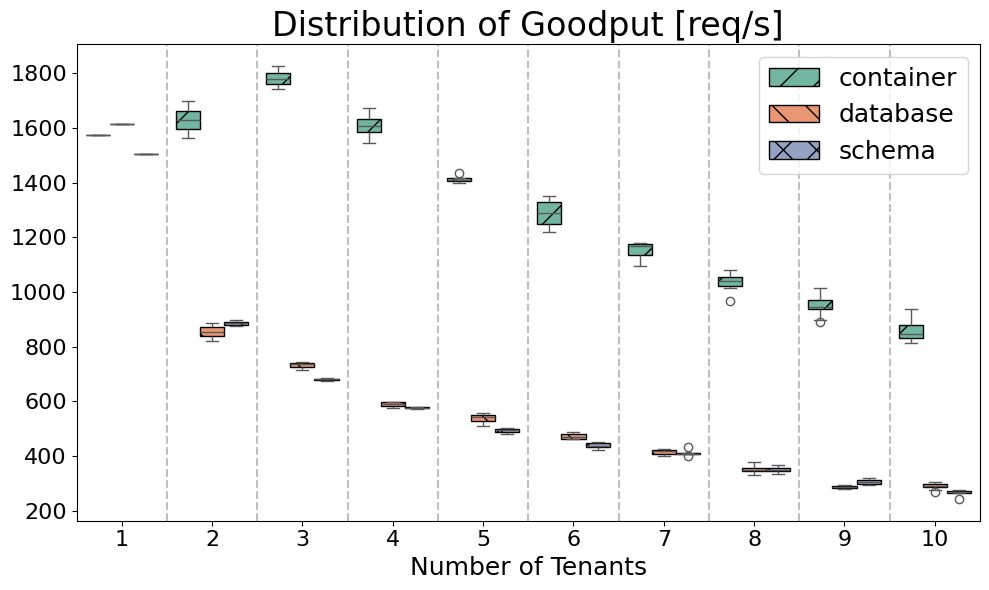

In [10]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()
plot_boxplots(df, y='Goodput (requests/second)', title='Distribution of Goodput [req/s]')

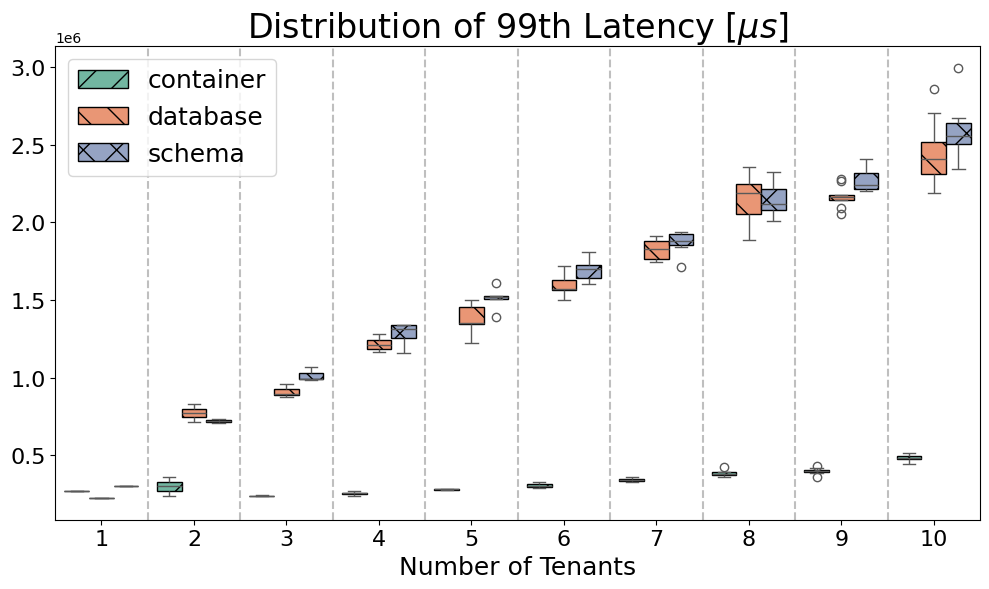

In [11]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()
plot_boxplots(df, y='Latency Distribution.99th Percentile Latency (microseconds)', title='Distribution of 99th Latency [$\mu s$]')


In [12]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants
0,1,1573.971516,6,62914.000000,267072,container,1
1,2,3752.529821,43,26257.000000,109435,container,1
0,1,3259.649810,30,60789.500000,357056,container,2
1,2,6690.324652,97,29462.000000,124921,container,2
0,1,5349.228066,71,55429.000000,241362,container,3
1,2,8393.221526,136,35217.333333,148843,container,3
0,1,6434.534533,84,61425.000000,265052,container,4
1,2,9456.329515,180,41651.750000,173112,container,4
0,1,7067.734660,86,69814.400000,282359,container,5
1,2,9906.644639,164,49688.200000,230145,container,5


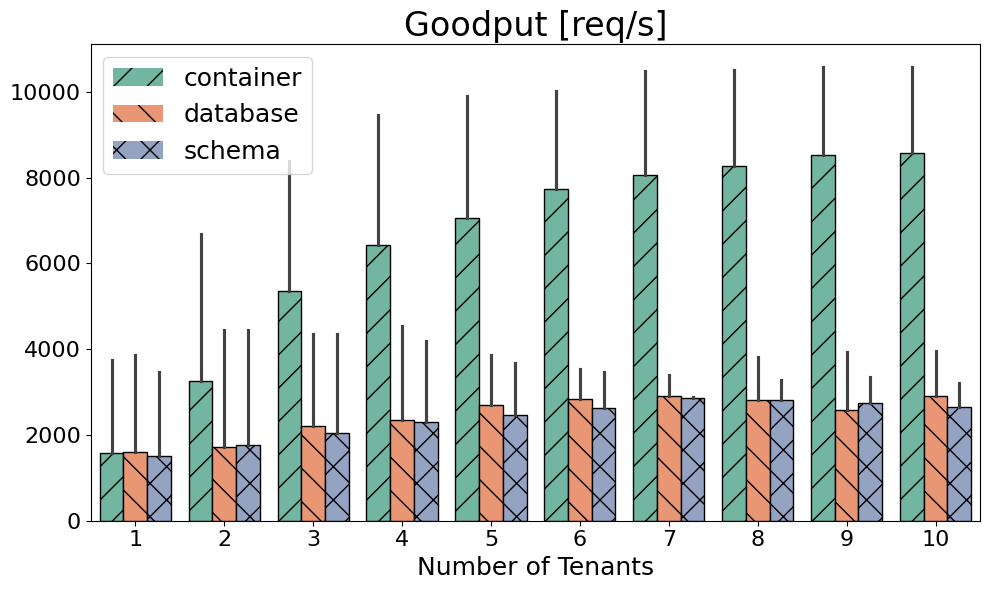

In [13]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

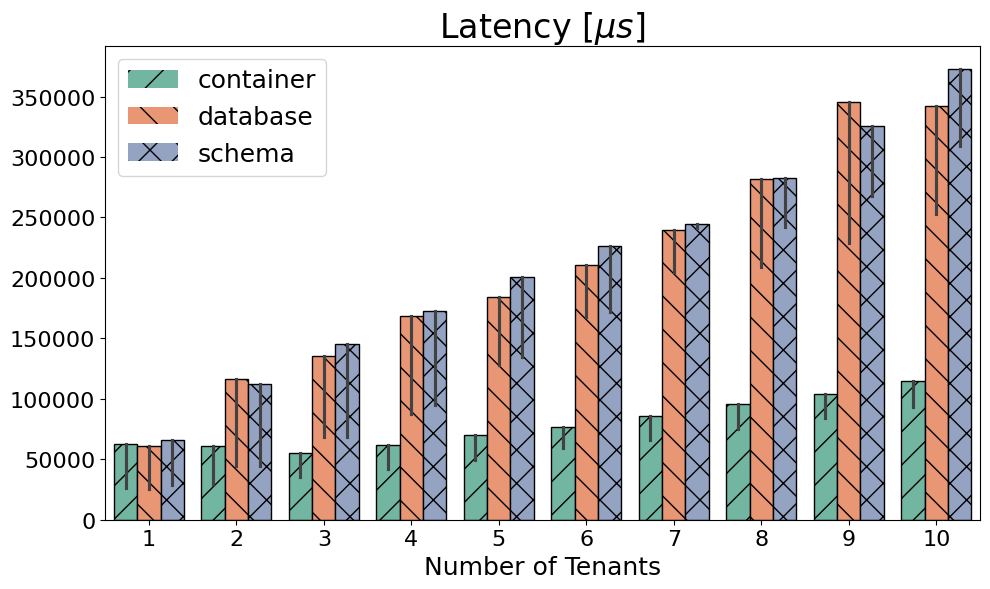

In [14]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

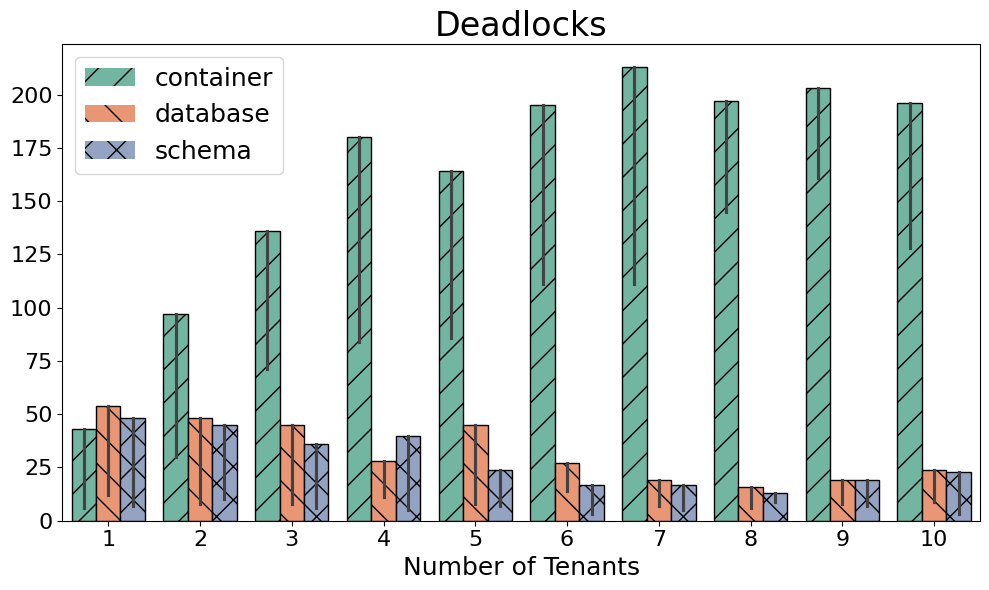

In [15]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [16]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-1-1-65536-0-1,261.0,104.0,157.0,1,1,0,1,2720,container,1
PostgreSQL-1-1-65536-0-2,261.0,104.0,157.0,1,1,0,2,6264,container,1
PostgreSQL-1-1-65536-0-1,324.0,136.0,188.0,1,1,0,1,2720,container,2
PostgreSQL-1-1-65536-0-2,324.0,136.0,188.0,1,1,0,2,6284,container,2
PostgreSQL-1-1-65536-1-1,302.0,115.0,187.0,1,1,1,1,2720,container,2
PostgreSQL-1-1-65536-1-2,302.0,115.0,187.0,1,1,1,2,6518,container,2
PostgreSQL-1-1-65536-0-1,265.0,104.0,161.0,1,1,0,1,2720,container,3
PostgreSQL-1-1-65536-0-2,265.0,104.0,161.0,1,1,0,2,6782,container,3
PostgreSQL-1-1-65536-1-1,279.0,118.0,161.0,1,1,1,1,2720,container,3
PostgreSQL-1-1-65536-1-2,279.0,118.0,161.0,1,1,1,2,6598,container,3


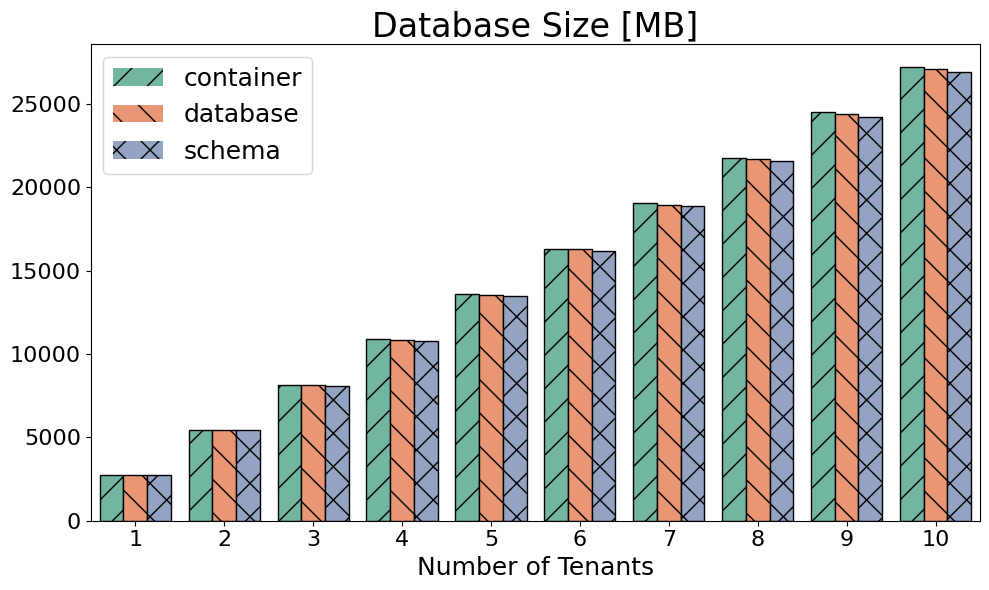

In [17]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

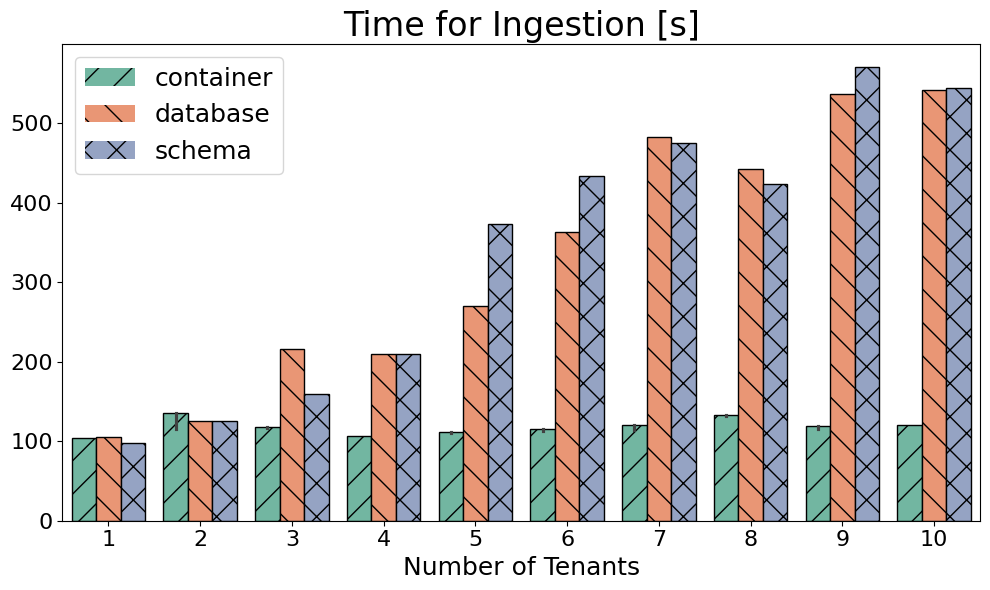

In [18]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

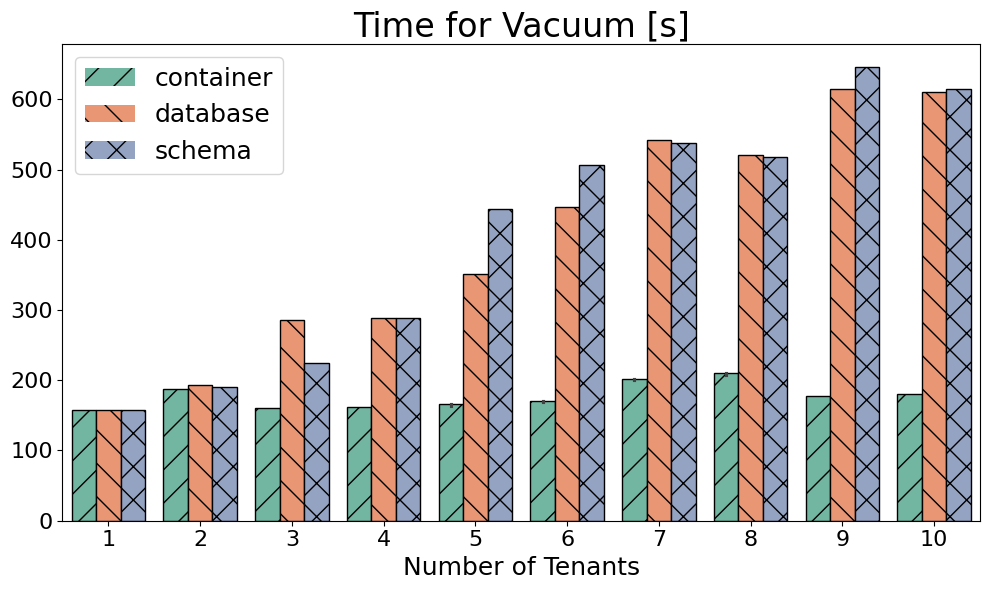

In [19]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

In [20]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,7969.80,5.19,7.08,18.47,container,1
0,1,18572.93,10.42,14.25,35.22,container,2
0,1,28905.17,15.78,21.64,49.34,container,3
0,1,31604.34,20.52,27.90,54.83,container,4
0,1,33848.08,25.17,34.00,57.49,container,5
0,1,34559.77,29.63,39.73,59.26,container,6
0,1,35471.47,34.00,45.34,59.88,container,7
0,1,35044.63,38.57,51.28,59.57,container,8
0,1,35036.49,42.70,56.42,59.30,container,9
0,1,36293.30,46.96,61.79,60.94,container,10


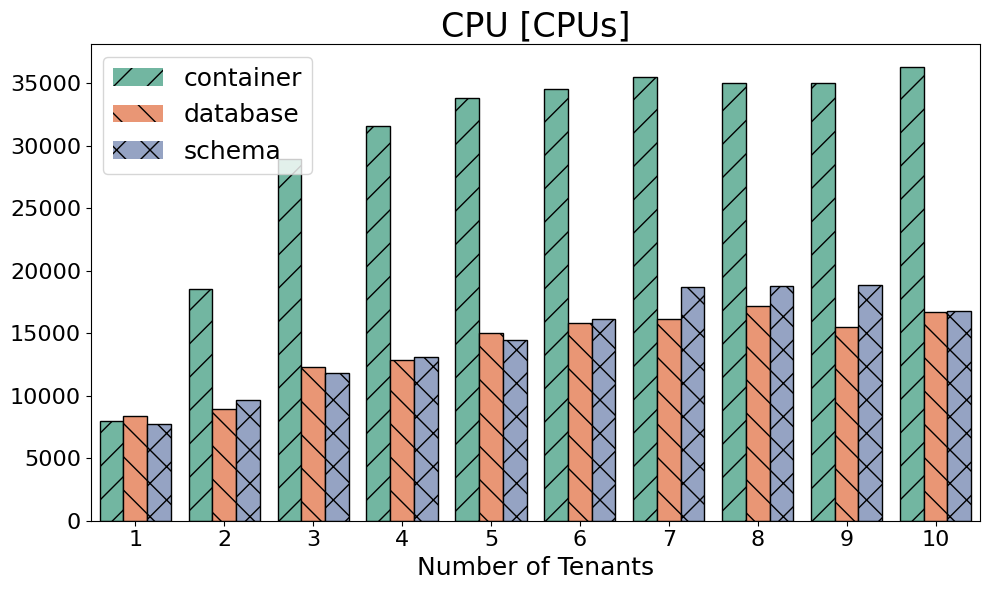

In [21]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

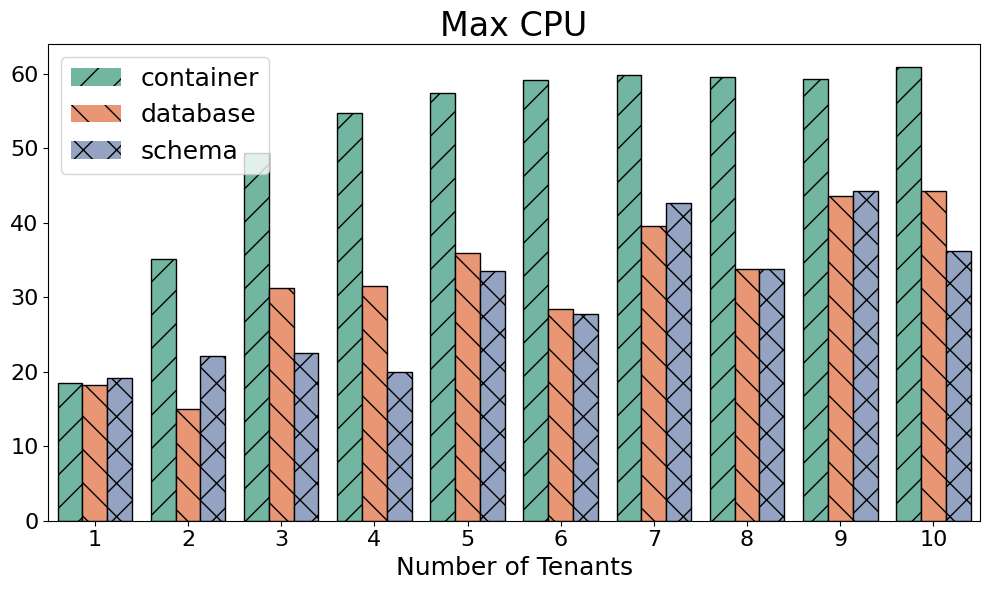

In [22]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

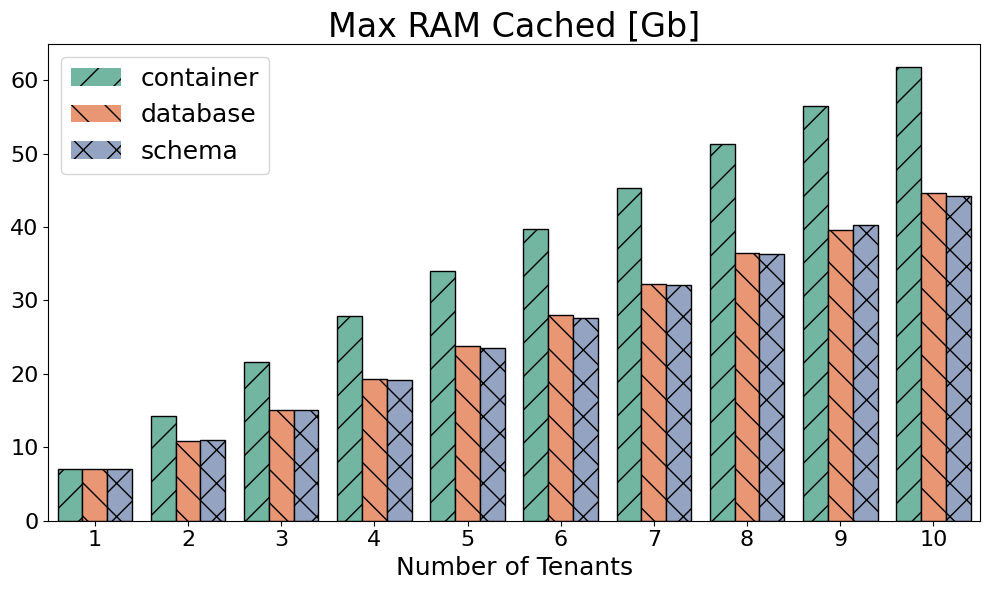

In [23]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Efficiency

In [24]:
df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == '2']
df_performance_monitoring

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
1,2,12247.36,7.35,11.06,22.35,container,1
1,2,23615.74,14.23,21.26,40.27,container,2
1,2,27549.11,20.67,30.63,47.80,container,3
1,2,30306.29,25.80,37.66,51.37,container,4
1,2,31887.17,30.76,44.31,54.23,container,5
1,2,32188.56,35.59,50.77,57.63,container,6
1,2,34264.95,40.32,57.02,57.95,container,7
1,2,34923.75,44.65,62.50,59.52,container,8
1,2,35194.67,49.02,68.10,59.49,container,9
1,2,35528.48,53.13,73.25,59.67,container,10


In [25]:
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == '2']
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants
1,2,3752.529821,43,26257.000000,109435,container,1
1,2,6690.324652,97,29462.000000,124921,container,2
1,2,8393.221526,136,35217.333333,148843,container,3
1,2,9456.329515,180,41651.750000,173112,container,4
1,2,9906.644639,164,49688.200000,230145,container,5
1,2,10009.044550,195,59045.000000,266039,container,6
1,2,10477.129684,213,65752.285714,309310,container,7
1,2,10507.049324,197,74971.000000,408931,container,8
1,2,10572.579223,203,83855.222222,459343,container,9
1,2,10578.512756,196,92964.500000,481977,container,10


In [26]:
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU
0,2,3752.529821,43,26257.000000,109435,container,1,2,12247.36,7.35,11.06,22.35
1,2,6690.324652,97,29462.000000,124921,container,2,2,23615.74,14.23,21.26,40.27
2,2,8393.221526,136,35217.333333,148843,container,3,2,27549.11,20.67,30.63,47.80
3,2,9456.329515,180,41651.750000,173112,container,4,2,30306.29,25.80,37.66,51.37
4,2,9906.644639,164,49688.200000,230145,container,5,2,31887.17,30.76,44.31,54.23
5,2,10009.044550,195,59045.000000,266039,container,6,2,32188.56,35.59,50.77,57.63
6,2,10477.129684,213,65752.285714,309310,container,7,2,34264.95,40.32,57.02,57.95
7,2,10507.049324,197,74971.000000,408931,container,8,2,34923.75,44.65,62.50,59.52
8,2,10572.579223,203,83855.222222,459343,container,9,2,35194.67,49.02,68.10,59.49
9,2,10578.512756,196,92964.500000,481977,container,10,2,35528.48,53.13,73.25,59.67


In [27]:
merged_df['Request/CPUs'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] / 600. * 1000.
merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600. * 1000.
merged_df['CPUs-99Latency'] = 1./np.sqrt(merged_df['Latency Distribution.99th Percentile Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
#merged_df['CPUs-99Latency'] = 1./(merged_df['Latency Distribution.99th Percentile Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['99Latency/CPUs'] = merged_df['Latency Distribution.99th Percentile Latency (microseconds)']/merged_df['CPU [CPUs]']/1E6
merged_df['CPUs-AvgLatency'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,Request/CPUs,CPUs/Request,CPUs-99Latency,99Latency/CPUs,CPUs-AvgLatency
0,2,3752.529821,43,26257.000000,109435,container,1,2,12247.36,7.35,11.06,22.35,0.510658,5.439601,0.027315,0.000009,0.055764
1,2,6690.324652,97,29462.000000,124921,container,2,2,23615.74,14.23,21.26,40.27,0.472166,5.883058,0.018411,0.000005,0.037911
2,2,8393.221526,136,35217.333333,148843,container,3,2,27549.11,20.67,30.63,47.80,0.507773,5.470508,0.015616,0.000005,0.032105
3,2,9456.329515,180,41651.750000,173112,container,4,2,30306.29,25.80,37.66,51.37,0.520042,5.341447,0.013806,0.000006,0.028146
4,2,9906.644639,164,49688.200000,230145,container,5,2,31887.17,30.76,44.31,54.23,0.517797,5.364610,0.011673,0.000007,0.025123
5,2,10009.044550,195,59045.000000,266039,container,6,2,32188.56,35.59,50.77,57.63,0.518251,5.359912,0.010806,0.000008,0.022938
6,2,10477.129684,213,65752.285714,309310,container,7,2,34264.95,40.32,57.02,57.95,0.509614,5.450753,0.009714,0.000009,0.021068
7,2,10507.049324,197,74971.000000,408931,container,8,2,34923.75,44.65,62.50,59.52,0.501428,5.539733,0.008368,0.000012,0.019543
8,2,10572.579223,203,83855.222222,459343,container,9,2,35194.67,49.02,68.10,59.49,0.500671,5.548105,0.007865,0.000013,0.018408
9,2,10578.512756,196,92964.500000,481977,container,10,2,35528.48,53.13,73.25,59.67,0.496246,5.597586,0.007642,0.000014,0.017400


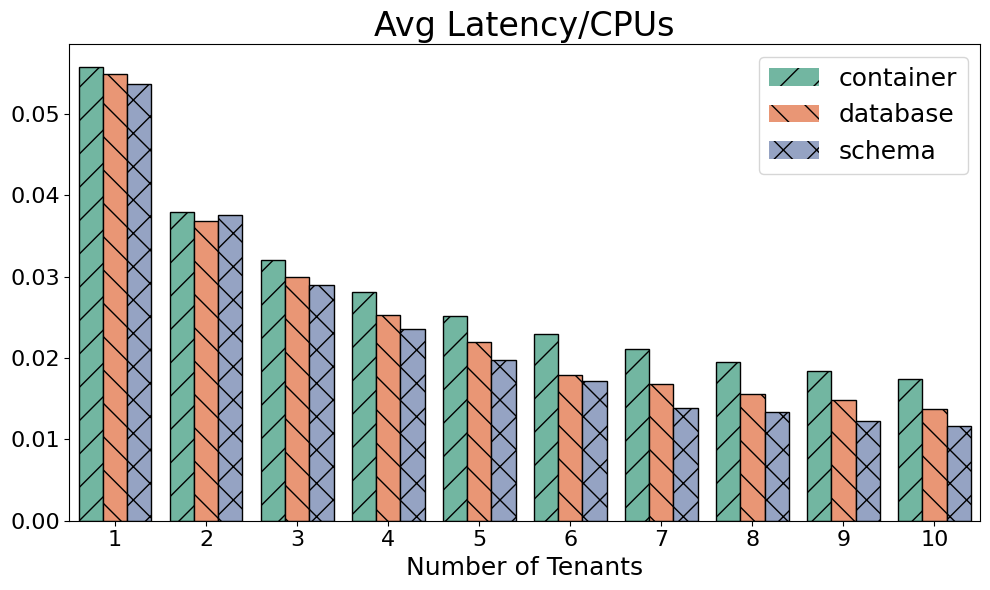

In [28]:
plot_bars(merged_df, y='CPUs-AvgLatency', title='Avg Latency/CPUs', estimator='max')

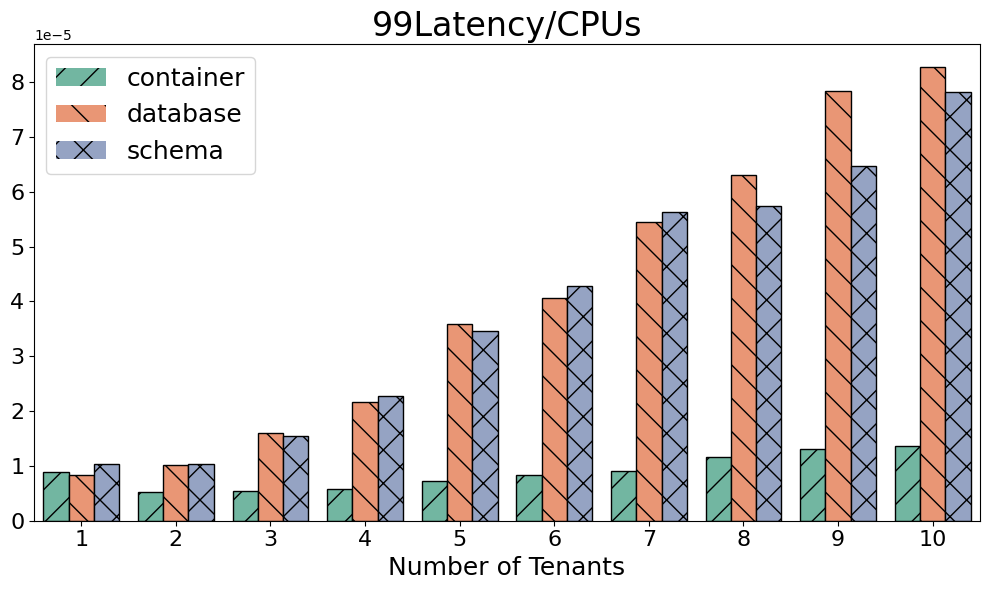

In [29]:
plot_bars(merged_df, y='99Latency/CPUs', title='99Latency/CPUs', estimator='max')

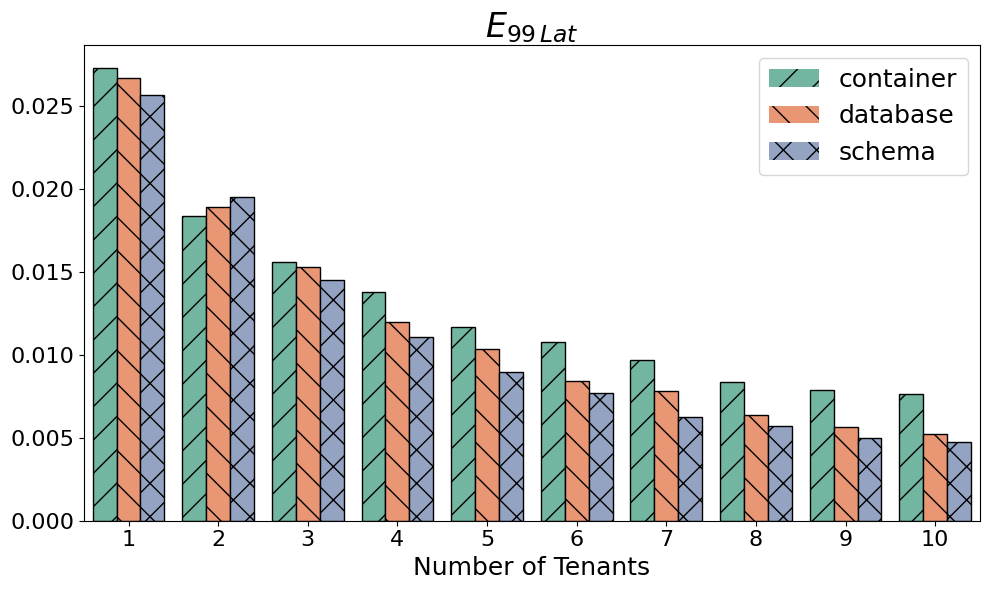

In [30]:
plot_bars(merged_df, y='CPUs-99Latency', title='$E_{99\,Lat}$', estimator='max')

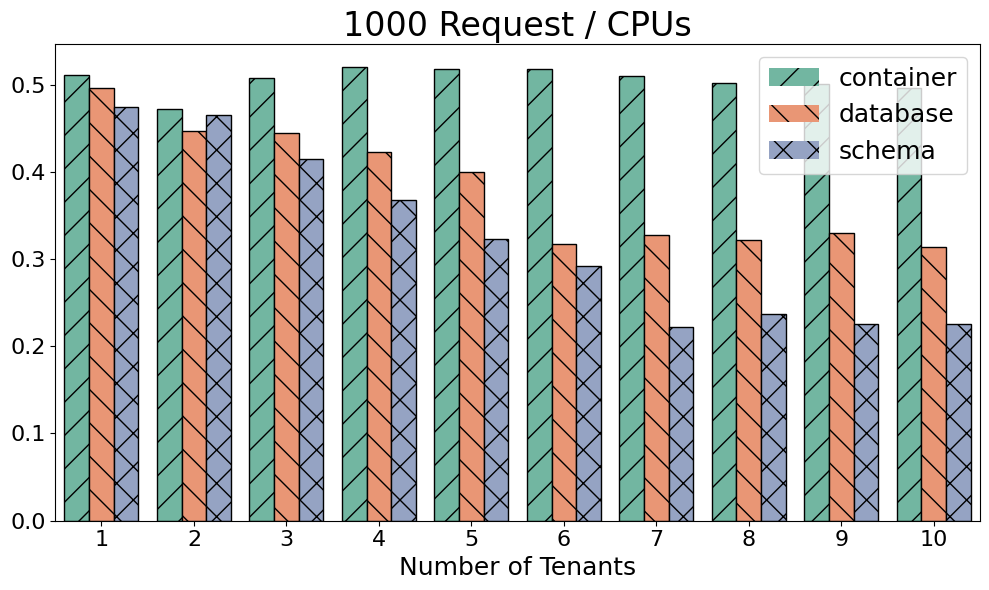

In [31]:
plot_bars(merged_df, y='Request/CPUs', title='1000 Request / CPUs', estimator='max')

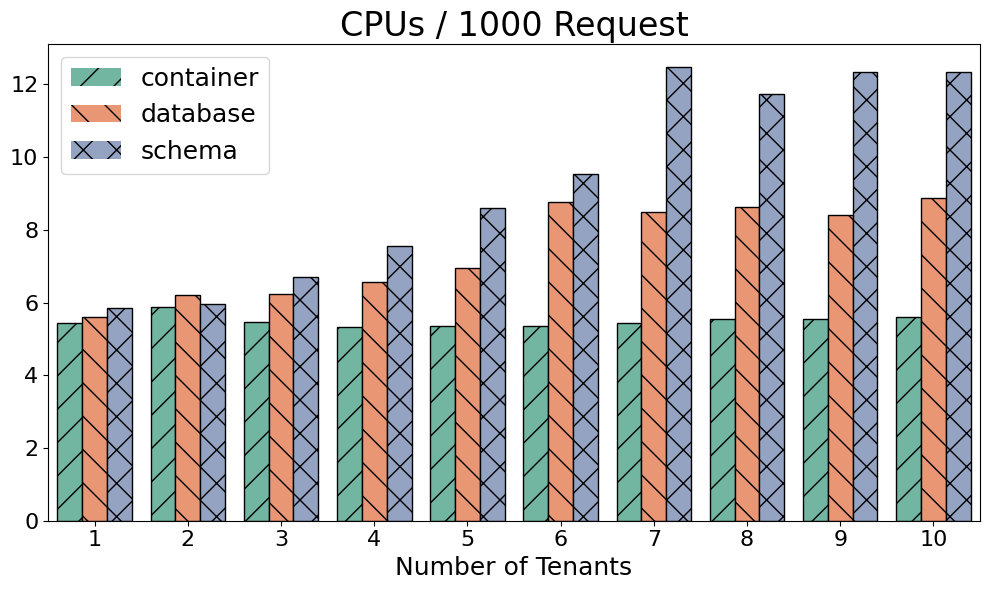

In [32]:
plot_bars(merged_df, y='CPUs/Request', title='CPUs / 1000 Request', estimator='max')

In [33]:
client = '1'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
merged_df['Request/CPUs'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600.
merged_df['CPUs-AvgLatency'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']
merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,Request/CPUs,CPUs/Request,CPUs-AvgLatency,E_RAM
0,1,1573.971516,6,62914.000000,267072,container,1,1,7969.80,5.19,7.08,18.47,118.495183,0.008439,0.044658,303.270042
1,1,3259.649810,30,60789.500000,357056,container,2,1,18572.93,10.42,14.25,35.22,105.303250,0.009496,0.029761,312.826277
2,1,5349.228066,71,55429.000000,241362,container,3,1,28905.17,15.78,21.64,49.34,111.036774,0.009006,0.024983,338.987837
3,1,6434.534533,84,61425.000000,265052,container,4,1,31604.34,20.52,27.90,54.83,122.157929,0.008186,0.022696,313.573808
4,1,7067.734660,86,69814.400000,282359,container,5,1,33848.08,25.17,34.00,57.49,125.284530,0.007982,0.020571,280.799947
5,1,7723.216164,111,76710.500000,327701,container,6,1,34559.77,29.63,39.73,59.26,134.084506,0.007458,0.019422,260.655287
6,1,8062.484634,111,85663.428571,357441,container,7,1,35471.47,34.00,45.34,59.88,136.376947,0.007333,0.018141,237.131901
7,1,8280.231278,145,95295.625000,423316,container,8,1,35044.63,38.57,51.28,59.57,141.766050,0.007054,0.017304,214.680614
8,1,8537.287884,161,103975.111111,428886,container,9,1,35036.49,42.70,56.42,59.30,146.201082,0.006840,0.016568,199.936484
9,1,8582.786228,128,115002.300000,510112,container,10,1,36293.30,46.96,61.79,60.94,141.890424,0.007048,0.015479,182.768020


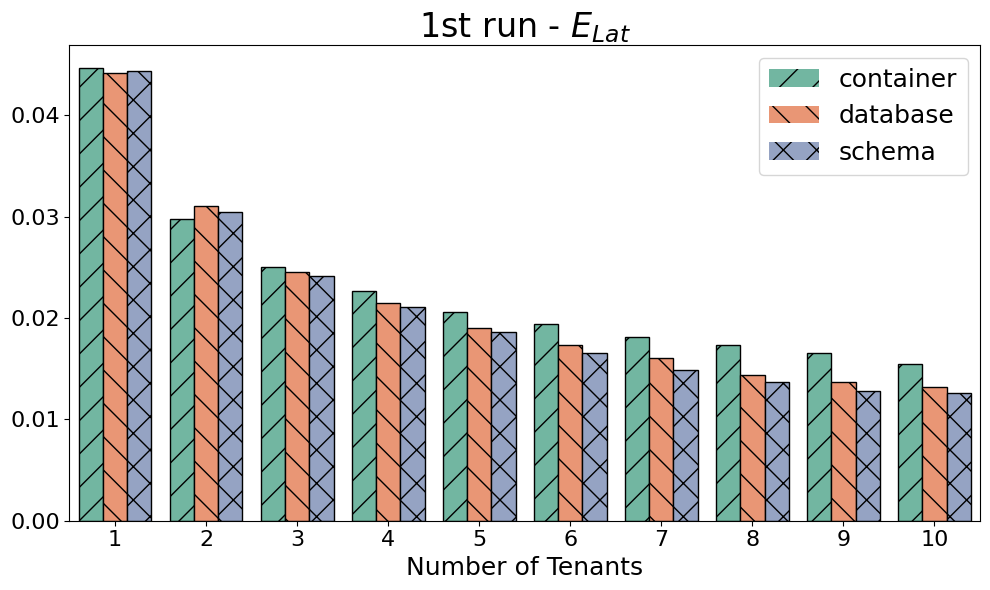

In [34]:
plot_bars(merged_df, y='CPUs-AvgLatency', title='1st run - $E_{Lat}$', estimator='max')

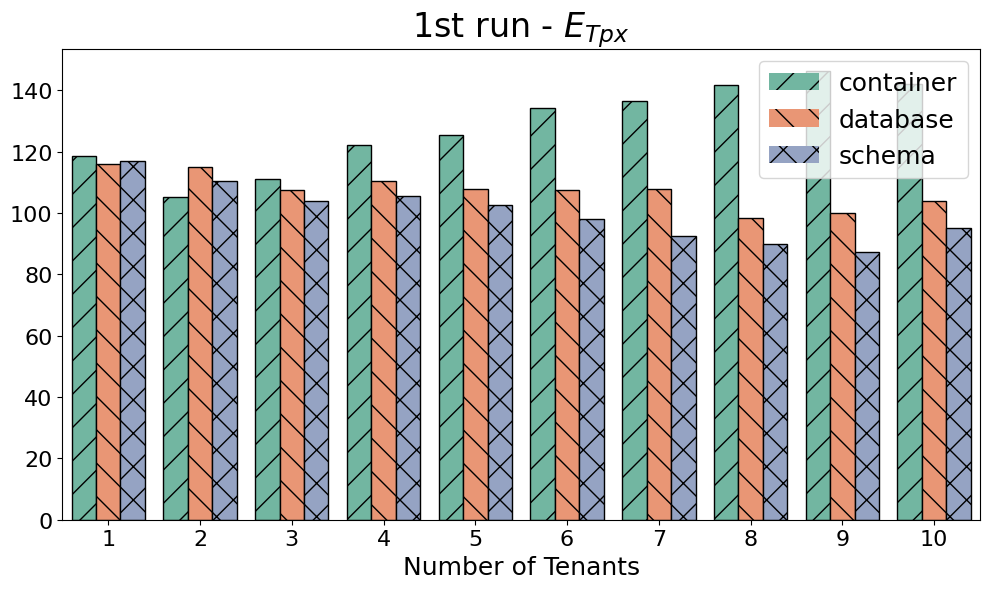

In [35]:
plot_bars(merged_df, y='Request/CPUs', title='1st run - $E_{Tpx}$', estimator='max')

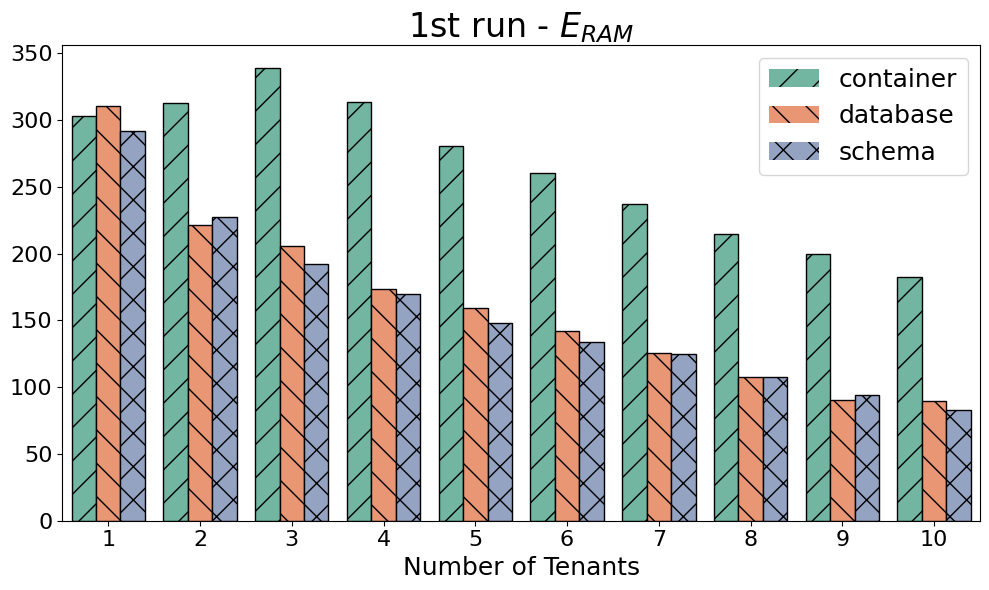

In [36]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='max')

In [37]:
client = '2'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
merged_df['Request/CPUs'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600.
merged_df['CPUs-AvgLatency'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']

merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,Request/CPUs,CPUs/Request,CPUs-AvgLatency,E_RAM
0,2,3752.529821,43,26257.000000,109435,container,1,2,12247.36,7.35,11.06,22.35,183.836998,0.005440,0.055764,510.548275
1,2,6690.324652,97,29462.000000,124921,container,2,2,23615.74,14.23,21.26,40.27,169.979632,0.005883,0.037911,470.156335
2,2,8393.221526,136,35217.333333,148843,container,3,2,27549.11,20.67,30.63,47.80,182.798389,0.005471,0.032105,406.058129
3,2,9456.329515,180,41651.750000,173112,container,4,2,30306.29,25.80,37.66,51.37,187.215186,0.005341,0.028146,366.524400
4,2,9906.644639,164,49688.200000,230145,container,5,2,31887.17,30.76,44.31,54.23,186.406846,0.005365,0.025123,322.062570
5,2,10009.044550,195,59045.000000,266039,container,6,2,32188.56,35.59,50.77,57.63,186.570220,0.005360,0.022938,281.231935
6,2,10477.129684,213,65752.285714,309310,container,7,2,34264.95,40.32,57.02,57.95,183.460878,0.005451,0.021068,259.849447
7,2,10507.049324,197,74971.000000,408931,container,8,2,34923.75,44.65,62.50,59.52,180.514108,0.005540,0.019543,235.320254
8,2,10572.579223,203,83855.222222,459343,container,9,2,35194.67,49.02,68.10,59.49,180.241711,0.005548,0.018408,215.678891
9,2,10578.512756,196,92964.500000,481977,container,10,2,35528.48,53.13,73.25,59.67,178.648444,0.005598,0.017400,199.106207


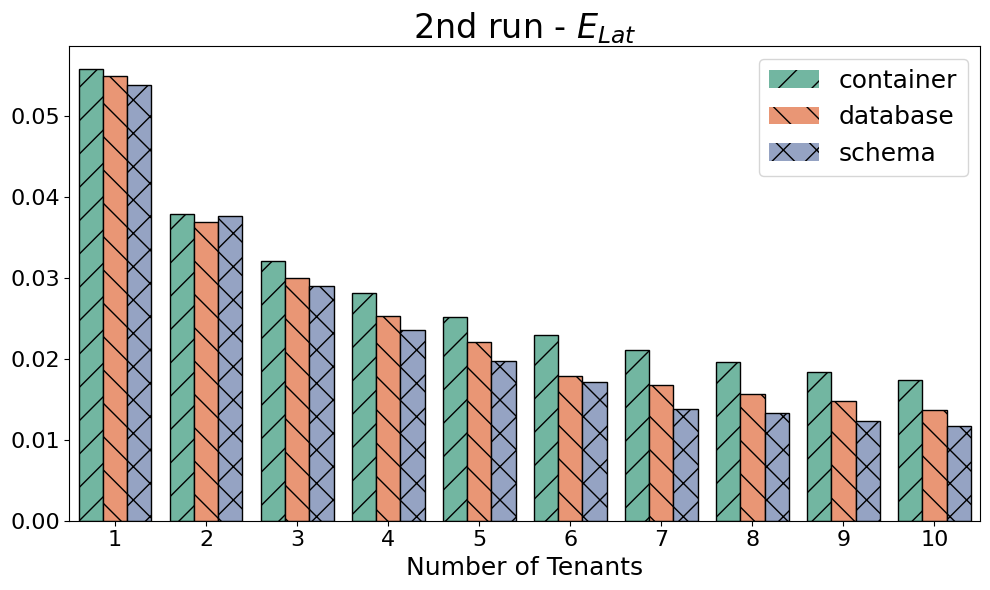

In [38]:
plot_bars(merged_df, y='CPUs-AvgLatency', title='2nd run - $E_{Lat}$', estimator='max')

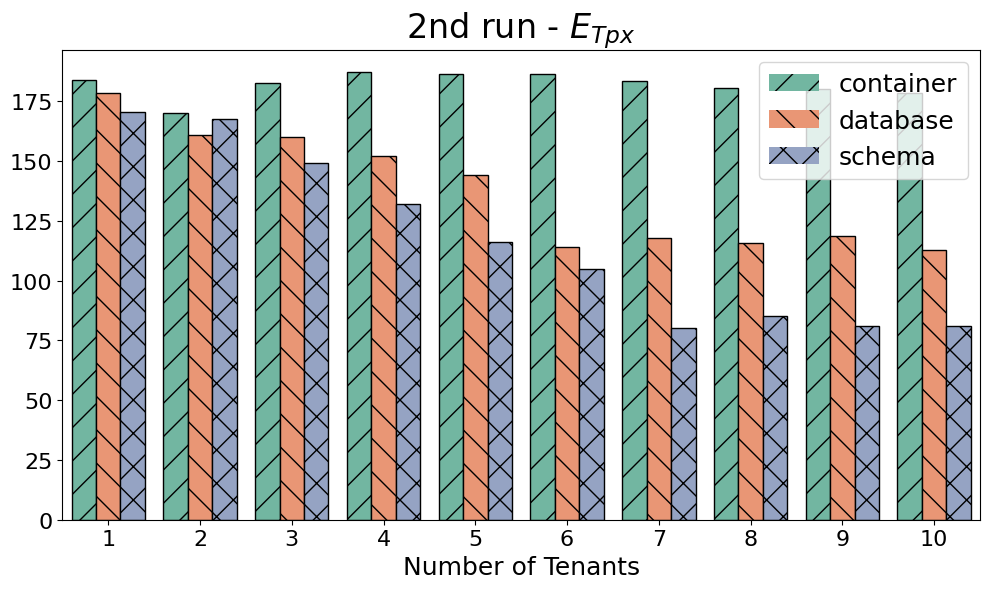

In [39]:
plot_bars(merged_df, y='Request/CPUs', title='2nd run - $E_{Tpx}$', estimator='max')

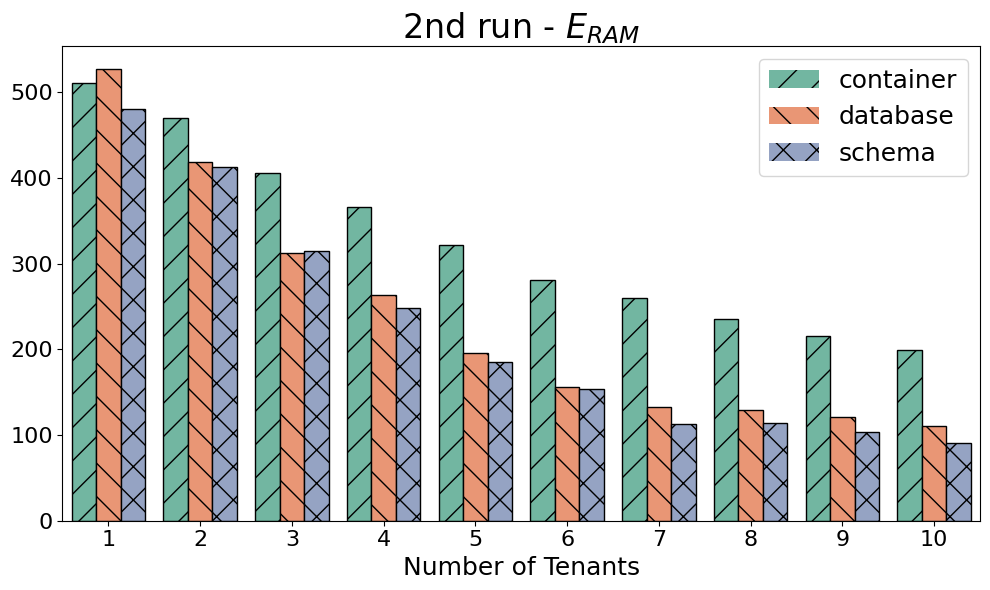

In [40]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')